In [1]:
import sys
print(sys.version)

import netCDF4 as nc
import numpy as np
#from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import matplotlib.pyplot as plt
from pathlib import Path
#import cartopy
from os import listdir
from os.path import isfile, join
import os
import xarray
from PIL import Image
import satpy
import cv2

#os.rename(r'file path\OLD file name.file type',r'file path\NEW file name.file type')
mypath = "NC/"
onlyfiles = [os.path.join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f))]
#print(onlyfiles)
for file in onlyfiles:
    if "clavrx_" in file:
        os.rename(file, file.replace("clavrx_", ""))

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


<ipython-input-15-7b1d3ec1fe34>:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c1 = ds.variables['refl_0_65um_nom'][:].filled(0).astype(np.uint8)
<ipython-input-15-7b1d3ec1fe34>:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c2 = ds.variables['refl_0_86um_nom'][:].filled(0).astype(np.uint8)
<ipython-input-15-7b1d3ec1fe34>:40: DeprecationWarni

RGB_contrast : [  0   2   4   6   8  10  12  14  17  19  21  23  25  27  29  31  34  36
  38  40  42  44  46  48  51  53  55  57  59  61  63  65  68  70  72  74
  76  78  80  82  85  87  89  91  93  95  97  99 102 104 106 108 110 112
 114 116 119 121 123 125 127 129 131 133 136 138 140 142 144 146 148 150
 153 155 157 159 161 163 165 167 170 172 174 176 178 180 182 184 187 189
 191 193 195 197 199 201 204 206 208 210 212 214 216 218 221 223 225 227
 229 231 233 235 238 240 242 244 246 248 250 252 255]
RGB_contrast : 
[  0   2   4   6   8  10  12  14  17  19  21  23  25  27  29  31  34  36
  38  40  42  44  46  48  51  53  55  57  59  61  63  65  68  70  72  74
  76  78  80  82  85  87  89  91  93  95  97  99 102 104 106 108 110 112
 114 116 119 121 123 125 127 129 131 133 136 138 140 142 144 146 148 150
 153 155 157 159 161 163 165 167 170 172 174 176 178 180 182 184 187 189
 191 193 195 197 199 201 204 206 208 210 212 214 216 218 221 223 225 227
 229 231 233 235 238 240 242 244 246 24

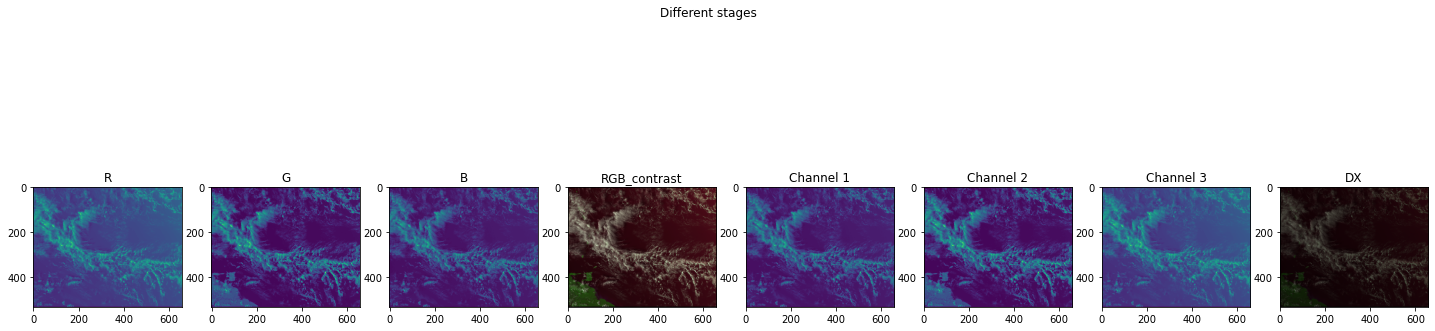

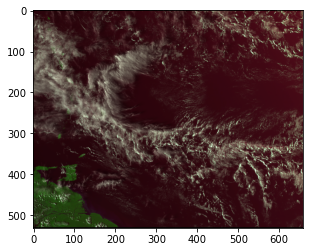

In [15]:
"""
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
"""
def contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR


def NormalizeData(arr):
    return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')

def norm(x):
    return (x-x.min())/(x.max()-x.min())

#path = "/bdd/EUREC4A/data/SATELLITES/GOES-E/0.5km_01min/2020/2020_01_12"
#path = "clavrx_OR_ABI-L1b-RadF-M6C01_G16_s20200221510168_BARBADOS-2KM-FD.level2.nc"
path = "NC/"
files_paths = []
files_paths = list(Path(path).rglob("*.[nN][cC]"))

files_paths = ["NC\OR_ABI-L1b-RadF-M6C01_G16_s20200222030165_BARBADOS-2KM-FD.level2.nc"]


for to_open in files_paths:
    C = xarray.open_dataset(to_open,mask_and_scale=False)
    ds = nc.Dataset(to_open)
    c1 = ds.variables['refl_0_65um_nom'][:].filled(0).astype(np.uint8)
    c2 = ds.variables['refl_0_86um_nom'][:].filled(0).astype(np.uint8)
    c3 = ds.variables['refl_0_47um_nom'][:].filled(0).astype(np.uint8)
    
    R = c3
    G = c2
    B = c1
    R = norm(R)
    G = norm(G)
    B = norm(B)
    
    # Apply the gamma correction
    """
    gamma = 0.4
    R = np.power(R, gamma).astype(np.uint8)
    G = np.power(G, gamma).astype(np.uint8)
    B = np.power(B, gamma).astype(np.uint8)
    
    
    # Calculate the "True" Green
    G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
    G_true = np.maximum(G_true, 0).astype(np.uint8)
    G_true = np.minimum(G_true, 1).astype(np.uint8)

    # Modify the RGB color contrast:
    contrast = 125
    """
    
    R = NormalizeData(R)
    G = NormalizeData(G)
    B = NormalizeData(B)    
    RGB_contrast = np.dstack([R, G, B])
    #RGB_contrast = RGB_contrast*(255/RGB_contrast.max())
    #RGB_contrast = contrast_correction(RGB_contrast, contrast)
    #RGB_contrast *= 255
    dx = np.dstack([c3, c2, c1])
    cv2.imwrite('Test_gray.jpg',RGB_contrast)
    cv2.imwrite('Test_gray2.jpg',dx)
    
    print("RGB_contrast : "+str(np.unique(RGB_contrast)))

    
    fig, axs = plt.subplots(1,8, figsize=(25,7))
    fig.suptitle('Different stages')
    
    axs[0].imshow(R)
    axs[0].title.set_text('R')
    axs[1].imshow(G)
    axs[1].title.set_text('G')
    axs[2].imshow(B)
    axs[2].title.set_text('B')

    axs[3].imshow(RGB_contrast)
    axs[3].title.set_text('RGB_contrast')
    
    axs[4].imshow(c1)
    axs[4].title.set_text('Channel 1')
    axs[5].imshow(c2)
    axs[5].title.set_text('Channel 2')
    axs[6].imshow(c3)
    axs[6].title.set_text('Channel 3')
    
    
    #print("DX UNIQUES : "+str(np.unique(dx)))
    axs[7].imshow(dx)
    axs[7].title.set_text('DX')
    
    print("RGB_contrast : \n"+str(np.unique(RGB_contrast)))    
    plt.figure()
    print(RGB_contrast.shape)
    plt.imshow(RGB_contrast)
plt.show()

In [7]:
import tqdm
for file in tqdm.tqdm(files_paths):
    ds = xarray.open_dataset(file)
    print(ds.keys())
    aspect_ratio = np.abs(np.nanmean(np.gradient(ds.latitude.values))/np.nanmean(np.gradient(ds.longitude.values)))
    plt.figure(figsize=(8,8))
    try:
        plt.imshow(ds.C13.squeeze(), cmap='RdBu_r', aspect=aspect_ratio, vmin=260, vmax=301)
    except:
        plt.imshow(ds.C02.squeeze(), cmap='binary_r', aspect=aspect_ratio, vmin=-10, vmax=80)
    plt.axis('off');
    plt.savefig(file.replace('.nc', '.jpeg'), bbox_inches='tight', pad_inches=0, dpi=354.9)
    plt.close('all')

  0%|          | 0/1 [00:00<?, ?it/s]

KeysView(<xarray.Dataset>
Dimensions:                            (pixel_elements_along_scan_direction: 658, scan_lines_along_track_direction: 531, the_third_dimension: 500)
Coordinates:
    latitude                           (scan_lines_along_track_direction, pixel_elements_along_scan_direction) float32 ...
    longitude                          (scan_lines_along_track_direction, pixel_elements_along_scan_direction) float32 ...
Dimensions without coordinates: pixel_elements_along_scan_direction, scan_lines_along_track_direction, the_third_dimension
Data variables: (12/93)
    scan_line_number                   (scan_lines_along_track_direction) float64 ...
    scan_line_time                     (scan_lines_along_track_direction) timedelta64[ns] ...
    bad_pixel_mask                     (scan_lines_along_track_direction, pixel_elements_along_scan_direction) float32 ...
    latitude_pc                        (scan_lines_along_track_direction, pixel_elements_along_scan_direction) float32

AttributeError: 'Dataset' object has no attribute 'C02'

<Figure size 576x576 with 0 Axes>